In [1]:
import warnings
from functools import partial

from pyspark.sql import SparkSession

import seaborn as sns
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, SparkTrials 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', category=ConvergenceWarning)

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Генерируем данные

In [2]:
CX, y = make_circles(n_samples=1_000, random_state=0, noise=0.05)

df = pd.DataFrame({
    'feat1': CX[:, 0],
    'feat2': CX[:, 1],
    'feat3': np.random.rand(CX.shape[0]),
    'feat4': np.random.normal(0, 5, CX.shape[0]),
    'target': y
})

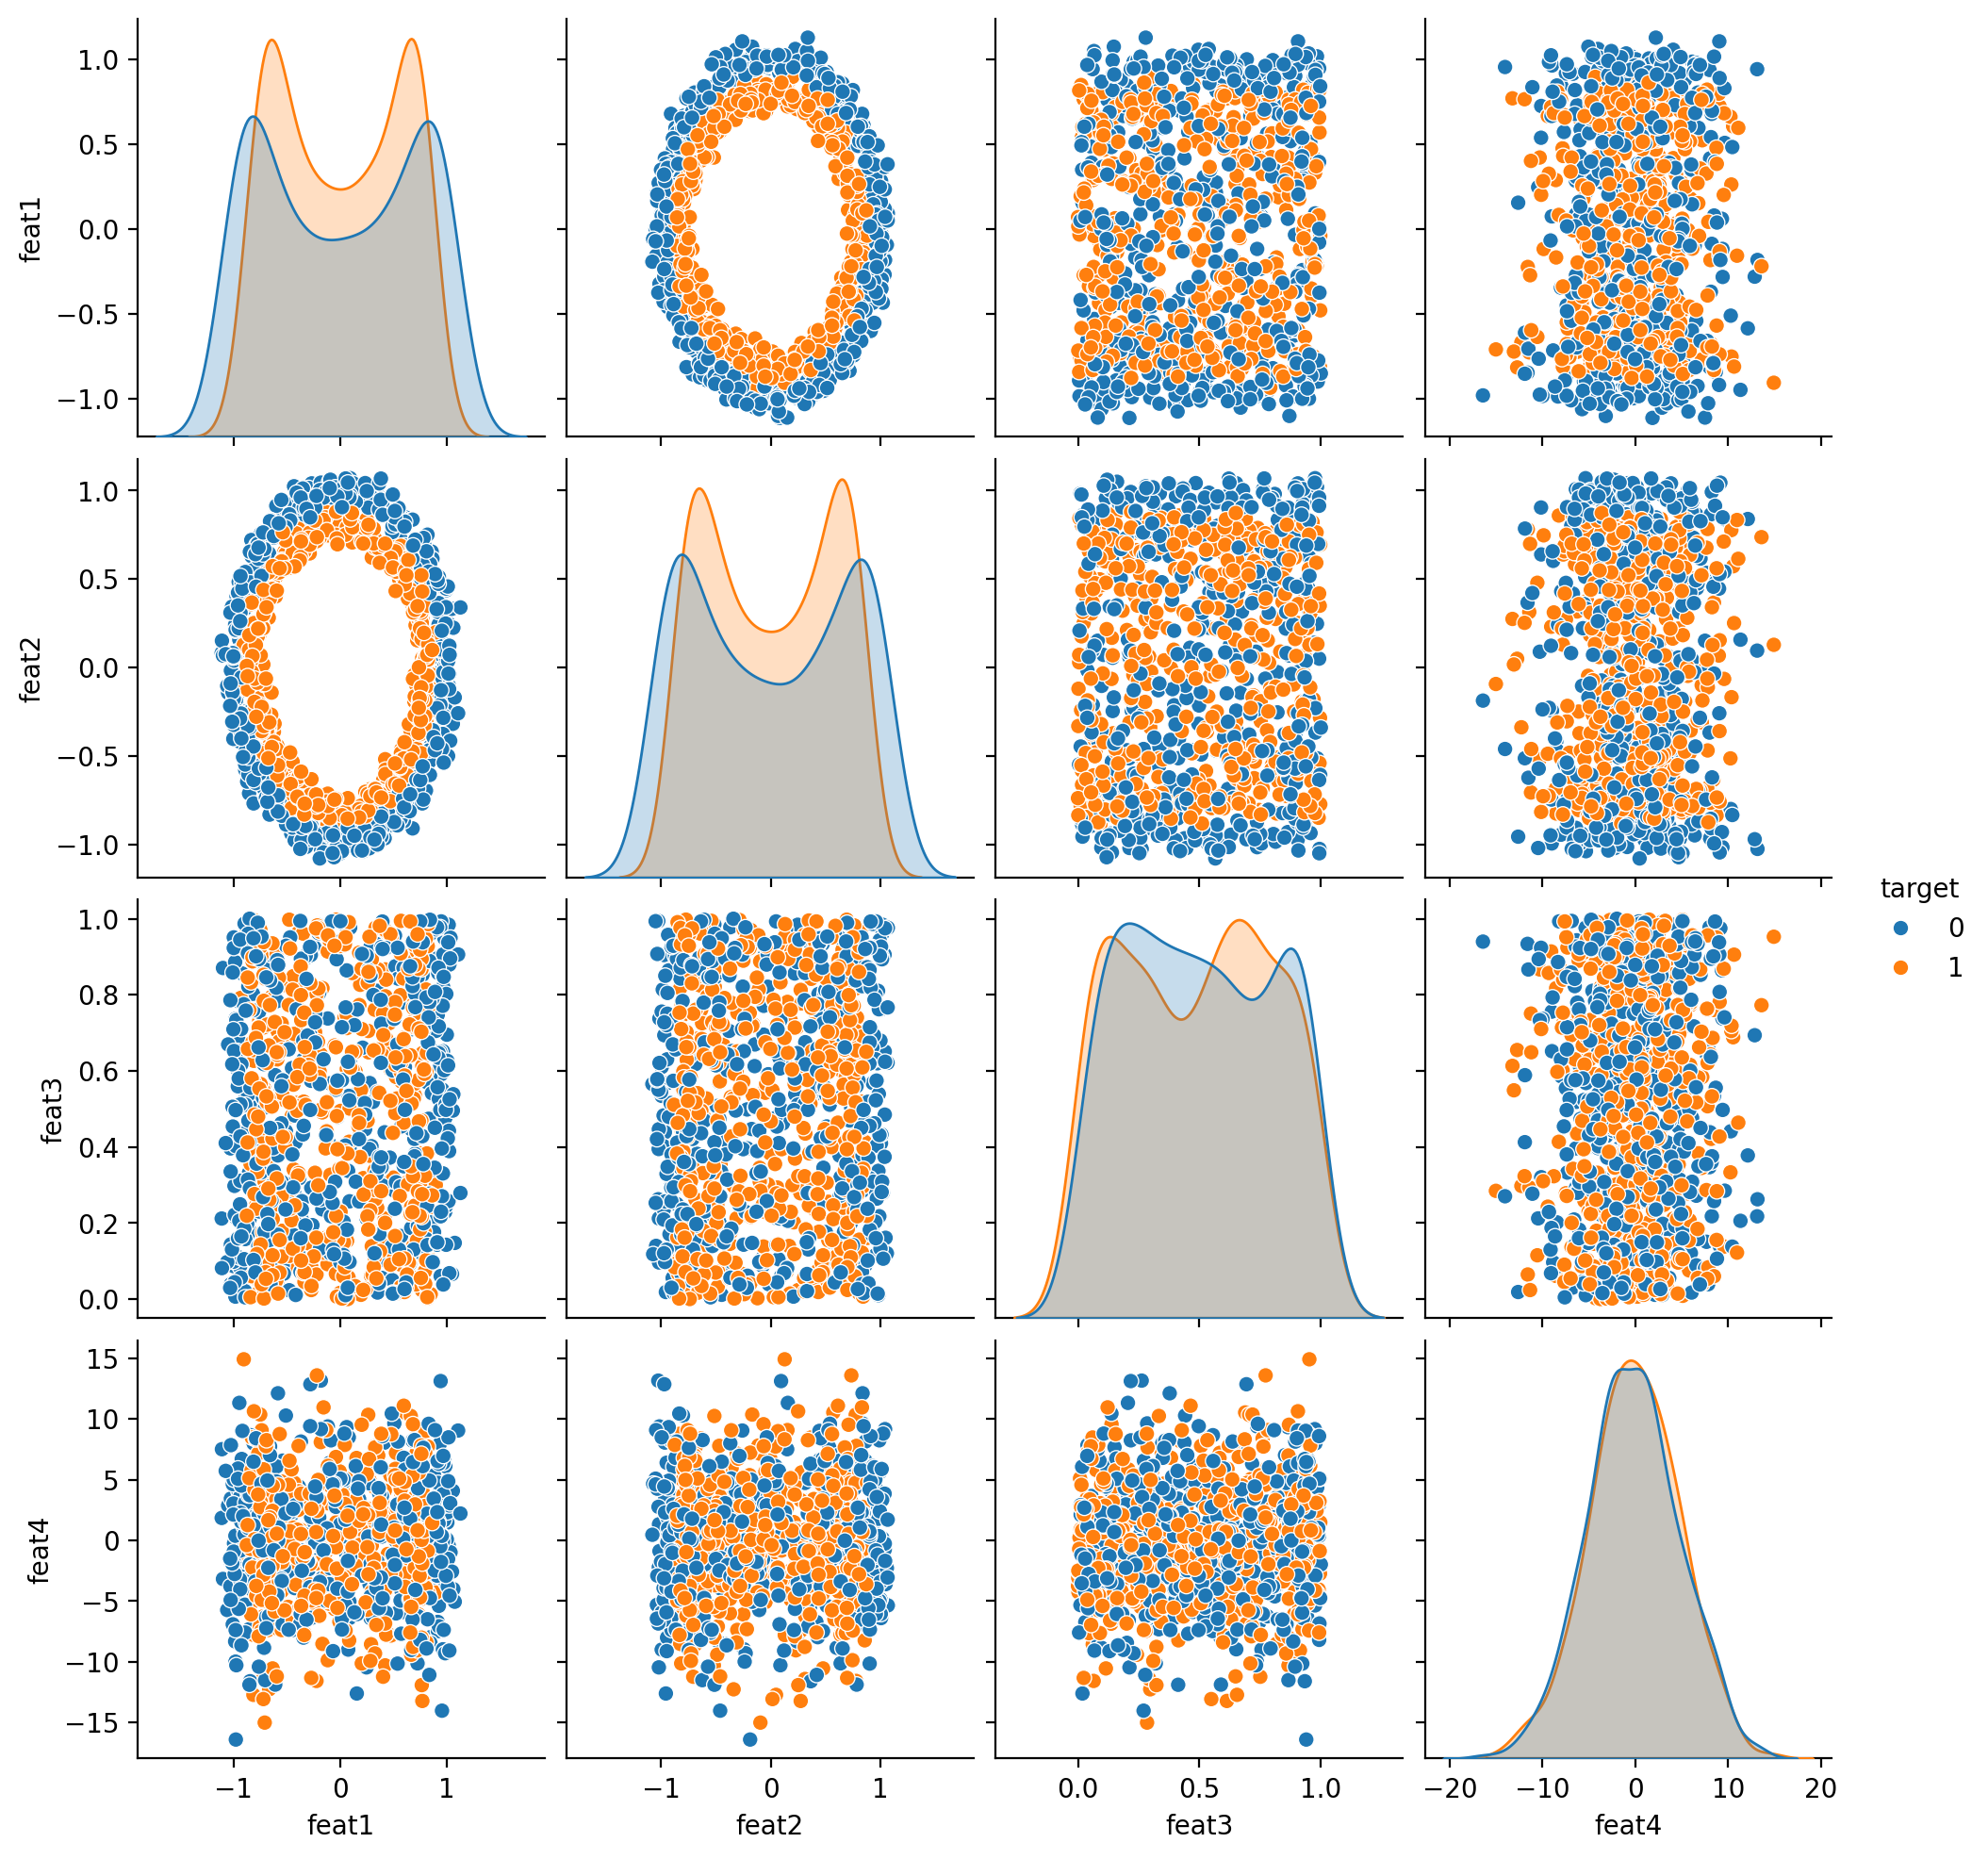

In [3]:
sns.pairplot(df, hue='target')

In [4]:
df.head()

,feat1,feat2,feat3,feat4,target
0,0.818621,-0.042336,0.228020,-2.670844,1
1,-0.117632,-0.714235,0.102760,-5.181066,1
2,-0.805155,-0.662227,0.171552,3.840754,0
3,0.552436,0.498088,0.090123,2.319705,1
4,-0.471866,0.656742,0.918954,-2.259955,1


## Определяем пространство поиска

<Axes: ylabel='Count'>

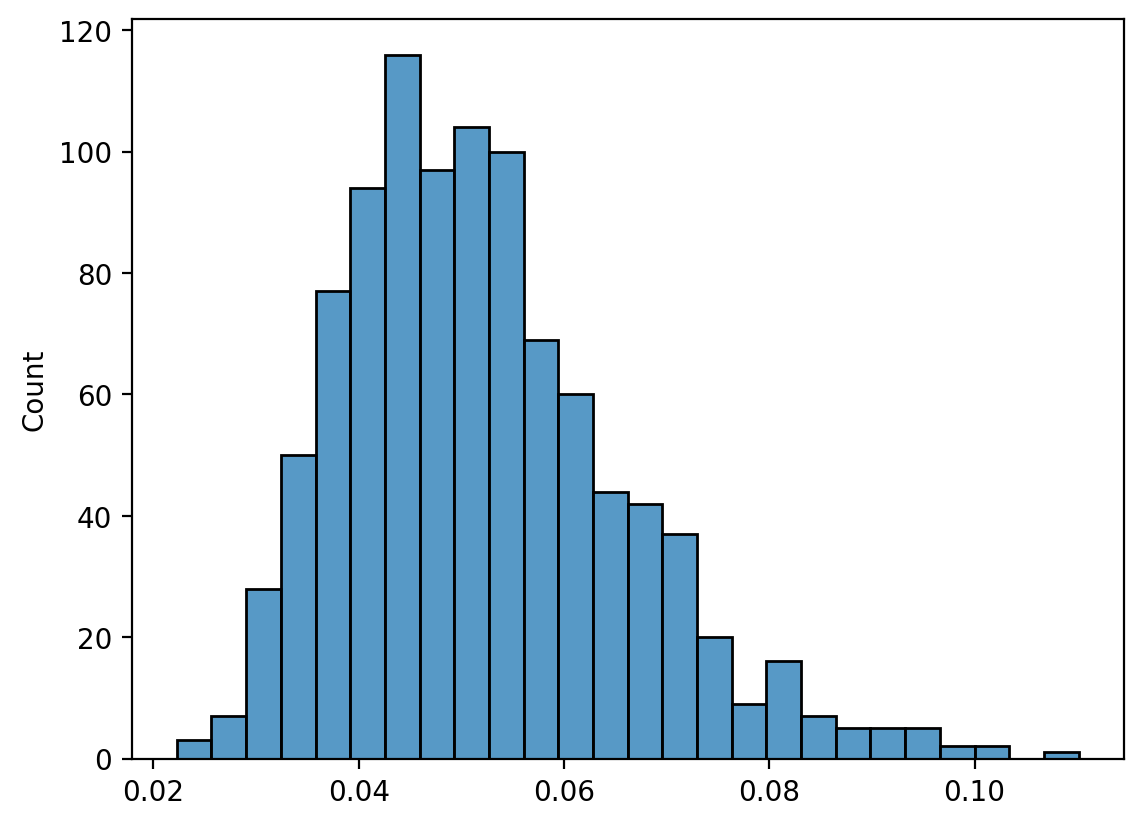

In [5]:
sns.histplot(np.random.lognormal(-3, 0.25, size=1000))

In [6]:
search_space = {
    'scaler': hp.choice(
        label = 'scaler_type',
        options = ['dummy_scaler','standard_scaler']
    ),
    'shape': hp.choice(
        label = 'network_shape',
        options = [
            (6, ),
            (6, 6),
            (12,),
            (24,),
            (12, 12),
            (12, 6, 3),
        ]
    ),
    'activation': hp.choice(
        label='activation_function',
        options = ['relu', 'logistic', 'tanh']
    ),
    'learning_rate': hp.lognormal(label='lr', mu=-3, sigma=.25),
    'alpha': hp.lognormal(label='alpha', mu=-10, sigma=1)
}

## Определяем функцию перебора

In [7]:
def objective(params, X_train, y_train):

    match params['scaler']:
        case 'dummy_scaler':
            scaler = FunctionTransformer(lambda x: x)
        case 'standard_scaler':
            scaler = StandardScaler()
        case _:
            return 0
            
    X_train = scaler.fit_transform(X_train)        

    model = MLPClassifier(
        hidden_layer_sizes=params['shape'],
        learning_rate_init=params['learning_rate'],
        activation=params['activation'],
    )
    
    accuracy = cross_val_score(model, X_train, y_train, cv=3).mean()
            
    return {'loss': -accuracy, 'status': STATUS_OK}

## Подбираем параметры умнее, чем раньше

In [8]:
spark = (
    SparkSession.
    builder.
    appName('hyperopt').
    config('spark.driver.memory', '2g').
    config('spark.executor.memory', '2g').
    getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/29 15:21:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 43902)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 295, in handle
    

In [9]:
X = df[['feat1', 'feat2', 'feat3', 'feat4']]
y = df['target']

trials = SparkTrials(spark_session=spark)

best = fmin(
    fn=partial(objective, X_train=X, y_train=y),
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)

Because the requested parallelism was None or a non-positive value, parallelism will be set to (16), which is Spark's default parallelism (16), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


  0%|                                                                                                                                          | 0/30 [00:00<?, ?trial/s, best loss=?]

  3%|███▋                                                                                                           | 1/30 [00:03<01:27,  3.01s/trial, best loss: -0.9249758740776706]

 10%|███████████                                                                                                    | 3/30 [00:04<00:31,  1.15s/trial, best loss: -0.9249758740776706]

 57%|██████████████████████████████████████████████████████████████▎                                               | 17/30 [00:18<00:13,  1.01s/trial, best loss: -0.9529919140697584]

 60%|██████████████████████████████████████████████████████████████████                                            | 18/30 [00:19<00:12,  1.01s/trial, best loss: -0.9529919140697584]

 63%|█████████████████████████████████████████████████████████████████████▋                                        | 19/30 [00:20<00:11,  1.01s/trial, best loss: -0.9599749450048852]

 67%|█████████████████████████████████████████████████████████████████████████▎                                    | 20/30 [00:21<00:10,  1.01s/trial, best loss: -0.9599749450048852]

 73%|████████████████████████████████████████████████████████████████████████████████▋                             | 22/30 [00:23<00:08,  1.01s/trial, best loss: -0.9599749450048852]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 27/30 [00:28<00:03,  1.01s/trial, best loss: -0.9599749450048852]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.04s/trial, best loss: -0.9599749450048852]


Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.


In [10]:
best

{'activation_function': 1,
 'alpha': 7.559863726001234e-05,
 'lr': 0.053713918280605295,
 'network_shape': 2,
 'scaler_type': 1}